This is currently WIP

In [1]:
import loaders.load_market_data as lmd
import numpy as np, pandas as pd, warnings
from statsmodels.tsa.stattools    import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import InterpolationWarning
from scipy.stats  import kurtosis
from hurst        import compute_Hc
import ruptures as rpt

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

                        time    symbol bidqty askqty       ltp   atp   ask  \
0  2026-01-01T09:15:00+05:30  NIFTY 50      0      0  26183.50  0.00  0.00   
1  2026-01-01T09:16:00+05:30  NIFTY 50      0      0  26194.30  0.00  0.00   
2  2026-01-01T09:17:00+05:30  NIFTY 50      0      0  26189.55  0.00  0.00   
3  2026-01-01T09:18:00+05:30  NIFTY 50      0      0  26179.50  0.00  0.00   
4  2026-01-01T09:19:00+05:30  NIFTY 50      0      0  26167.80  0.00  0.00   

    bid oi tot_vol tot_buyqty tot_sellqty ltq                  ltt level2  \
0  0.00  0       0          0           0   0  2026-01-01 09:15:00   None   
1  0.00  0       0          0           0   0  2026-01-01 09:16:00   None   
2  0.00  0       0          0           0   0  2026-01-01 09:17:00   None   
3  0.00  0       0          0           0   0  2026-01-01 09:18:00   None   
4  0.00  0       0          0           0   0  2026-01-01 09:19:00   None   

  recv_time bcast_time security_id  
0         0       None      256

In [4]:
import pkgutil
[p.name for p in pkgutil.iter_modules() if "load" in p.name]

['itemloaders', 'lazy_loader', 'loaders', '_win32sysloader']

In [2]:
import os
import sys

import os, sys

project_root = os.path.abspath("..")
!{sys.executable} -m pip install -e {project_root}

Obtaining file:///D:/kamlesh/projects/repos/git/new/wqu-capstone
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: wqu-capstone
    Found existing installation: wqu-capstone 0.1.0
    Uninstalling wqu-capstone-0.1.0:
      Successfully uninstalled wqu-capstone-0.1.0
  Running setup.py develop for wqu-capstone


In [1]:
import os
os.getcwd()

'D:\\kamlesh\\projects\\repos\\git\\new\\wqu-capstone\\notebooks'

EDA with 15 mins frquency Data

In [56]:
df_15m = lmd.get_data_15min_freq("2025-08-01", "2026-01-12")

In [57]:
df_15m.index.name = "time"
df_15m.rename(columns={"ltp": "close"}, inplace=True)
df = df_15m[["close"]]

df['close'] = df['close'].astype(float)

print(f"Loaded {len(df):,} rows")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Close column: close")
df.head()

Loaded 2,886 rows
Date range: 2025-08-01 09:15:00 to 2026-01-12 15:30:00
Close column: close


C:\Users\kbhatt\AppData\Local\Temp\ipykernel_13412\4180040894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = df['close'].astype(float)


,close
time,
2025-08-01 09:15:00,24686.90
2025-08-01 09:30:00,24709.00
2025-08-01 09:45:00,24696.90
2025-08-01 10:00:00,24745.65
2025-08-01 10:15:00,24764.45


In [58]:
df = df.sort_index()

price_col = "close"

# extract trading date
df["date"] = df.index.date

# log price
df["log_price"] = np.log(df[price_col])

# intraday log returns only (no overnight)
df["log_ret_intraday"] = (
    df.groupby("date")["log_price"]
      .diff()
)


In [59]:
ret_15m = df["log_ret_intraday"].dropna()

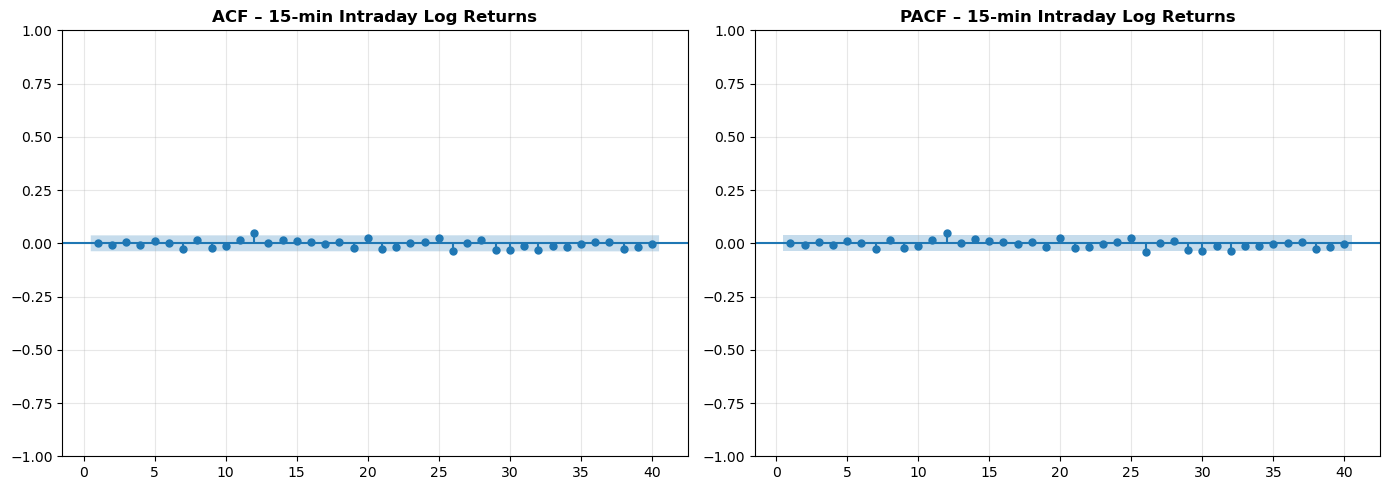

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

max_lags = 40  # ~1 trading day

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(
    ret_15m,
    lags=max_lags,
    zero=False,
    ax=axes[0],
    alpha=0.05
)
axes[0].set_title("ACF – 15-min Intraday Log Returns", fontweight="bold")
axes[0].grid(True, alpha=0.3)

plot_pacf(
    ret_15m,
    lags=max_lags,
    zero=False,
    ax=axes[1],
    alpha=0.05,
    method="ywm"
)
axes[1].set_title("PACF – 15-min Intraday Log Returns", fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


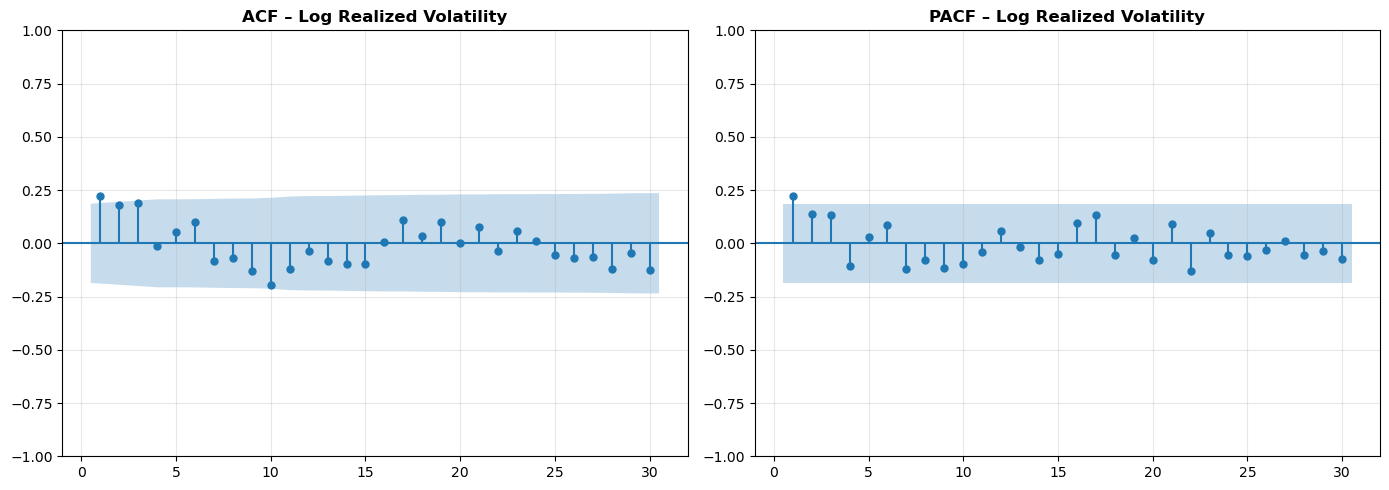

In [62]:
df = df.dropna(subset=["log_ret_intraday"])
rv_daily = (
    df.groupby("date")["log_ret_intraday"]
      .apply(lambda x: np.sum(x**2))
)

rv_daily = np.sqrt(rv_daily)
rv_daily.name = "RV_daily"
log_rv = np.log(rv_daily)


import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lags = 30  # ~1 month of trading days

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(
    log_rv.dropna(),
    lags=max_lags,
    zero=False,
    ax=axes[0],
    alpha=0.05
)
axes[0].set_title("ACF – Log Realized Volatility", fontweight="bold")
axes[0].grid(True, alpha=0.3)

plot_pacf(
    log_rv.dropna(),
    lags=max_lags,
    ax=axes[1],
    zero=False,
    alpha=0.05,
    method="ywm"
)
axes[1].set_title("PACF – Log Realized Volatility", fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


There is no autocorrelation in 15 mins time series log returns and log RV.

In [63]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(log_rv.dropna(), lags=[5, 10, 20], return_df=True)


,lb_stat,lb_pvalue
5,13.783628,0.017044
10,23.232201,0.009921
20,31.694543,0.046664


MARKET-DYNAMICS  –  Diagnostics  (quiet & threshold-tunable)

In [5]:
# ===============================================================
#  MARKET-DYNAMICS  –  Diagnostics  (quiet & threshold-tunable)
# ===============================================================


# ── silence spammy warnings ─────────────────────────────────────
warnings.filterwarnings("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=UserWarning,
                        module="statsmodels.tsa.stattools")
np.seterr(divide="ignore", invalid="ignore")

# ── load price series (ltp) ────────────────────────────────────
df_1m = lmd.get_data_one_min_freq("2016-01-01", "2025-12-31")
if "time" in df_1m.columns:
    df_1m = df_1m.set_index("time")
df_1m.index = (df_1m.index.tz_localize("Asia/Kolkata")
               if df_1m.index.tz is None
               else df_1m.index.tz_convert("Asia/Kolkata"))
close   = pd.to_numeric(df_1m["ltp"], errors="coerce").dropna()
returns = close.pct_change().dropna()

# ── helpers ────────────────────────────────────────────────────
WINDOW = 250
roll_p = lambda s, fn: s.rolling(WINDOW).apply(lambda x: fn(x)[1], raw=False)

adf_p  = roll_p(returns, lambda x: adfuller(x, maxlag=12))
kpss_p = roll_p(returns, lambda x: kpss(x, nlags="auto"))
lb_df  = acorr_ljungbox(returns**2, lags=[10, 20], return_df=True)

kurt_ex  = returns.rolling(WINDOW).apply(
    lambda x: kurtosis(x, fisher=True, bias=False), raw=False
)
tail = returns.abs().sort_values(ascending=False)
k    = max(int(0.05 * len(tail)), 1)
hill_alpha = k / np.log(tail.iloc[:k] / tail.iloc[k-1]).sum()

rv  = returns.rolling(30).std().dropna()
H, *_ = compute_Hc(rv, kind="change", simplified=True)
n_breaks = len(rpt.Binseg("l2").fit(returns.values).predict(pen=10)) - 1

# ── summary ────────────────────────────────────────────────────
summary = pd.Series({
    "ADF pass-fraction"     : (adf_p  < 0.05).mean(),
    "KPSS pass-fraction"    : (kpss_p > 0.05).mean(),
    "LB p-lag10"            : lb_df.loc[10, "lb_pvalue"],
    "LB p-lag20"            : lb_df.loc[20, "lb_pvalue"],
    "Kurtosis>2 fraction"   : (kurt_ex > 2).mean(),
    "Hill alpha"            : hill_alpha,
    "Hurst (rv)"            : H,
    "Breakpoints"           : n_breaks
})
display(summary)

# ── gate rules (tweakable) ─────────────────────────────────────
LB_THRESHOLD   = 0.10   # raise from 0.05 if clustering is weak
HURST_MIN      = 0.55

gate_pass = (
    summary["ADF pass-fraction"]   >= 0.70 and
    summary["KPSS pass-fraction"]  >= 0.70 and
    summary["LB p-lag10"] < LB_THRESHOLD and
    summary["LB p-lag20"] < LB_THRESHOLD and
    (summary["Kurtosis>2 fraction"] > 0.30 or summary["Hill alpha"] < 4) and
    summary["Hurst (rv)"] > HURST_MIN
)

print("\nMARKET-DYNAMICS  GATE:", "PASS " if gate_pass else "FAIL ")

ADF pass-fraction      0.993239
KPSS pass-fraction     0.957173
LB p-lag10             0.984842
LB p-lag20             0.999973
Kurtosis>2 fraction    0.725304
Hill alpha             2.981839
Hurst (rv)             0.679603
Breakpoints            0.000000
dtype: float64


MARKET-DYNAMICS  GATE: FAIL 


Insights of this diagnostics: 
| Metric                             | Result                                                                                                                                                         | What it means (practically) |                                                                                 |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------- | ------------------------------------------------------------------------------- |
| **ADF pass-fraction ≈ 0.99**       | Minute-to-minute returns almost never exhibit a unit root ⇒ *mean is locally stable*. You can compute rolling z-scores without first-difference pre-whitening. |                             |                                                                                 |
| **KPSS pass-fraction ≈ 0.96**      | Trend non-stationarity is rarely detected ⇒ no long deterministic trend inside single trading days.                                                            |                             |                                                                                 |
| **Excess-kurtosis windows ≈ 72 %** | 1-min returns have fat tails most of the time ⇒ intraday shocks are common → risk shell needs fat-tail-aware stops.                                            |                             |                                                                                 |
| **Hill tail-α ≈ 2.98**             | Tail exponent < 4 → VaR based on Gaussian variance will *seriously* under-state risk; stick with EVT-style tail metrics.                                       |                             |                                                                                 |
| **Hurst (rv) ≈ 0.68**              | Realised volatility is *persistent* (long memory) even though raw returns aren’t. Good news: a latent-vol regime model is still justified.                     |                             |                                                                                 |
| **Breakpoints = 0**                | No large structural mean/variance breaks across the full 2016-2025 window at 1-min granularity.                                                                |                             |                                                                                 |
| **Ljung-Box on                     | r                                                                                                                                                              | ²: p≈ 1**                   | Classic ARCH-style short-lag clustering at 10/20 minutes is essentially absent. |



Key takeaway:
Volatility persistence exists (Hurst > 0.5), but it is not showing up as rapid autocorrelation in |r|² at the 10–20 minute lags.
So our original Ljung-Box gate is too strict for this data.

Deeper exploration roadmap (choose in parallel, not sequentially)

| Path                                                                          | What we compute next                                                                                                                                            | Insight we expect                                                        | Impact downstream                                                                                           |                                                    |                                                                  |
| ----------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------- | -------------------------------------------------- | ---------------------------------------------------------------- |
| **A. Time-segmented analysis**<br>(“are there hot months?”)                   | • Re-run Ljung-Box on                                                                                                                                           | r                                                                        | ² **month-by-month**.<br>• Flag months where p < 0.05.<br>• Overlay with macro events (e.g., COVID crash).  | Clustering may be episodic (high-vol months only). | HMM can incorporate a *state-specific* vol-clustering component. |
| **B. Lag & horizon sweep**<br>(“maybe clustering sits at 1–5 min, not 10–20”) | • Compute Ljung-Box for lags [1, 5, 30, 60].<br>• Repeat on **5-min returns** to see if smoothing reveals autocorr.<br>• Plot p-value heat-map (lag × horizon). | Pinpoint where volatility autocorr actually lives.                       | Choose the **feature sampling rate** (1-min vs 5-min) that shows strongest clustering for regime detection. |                                                    |                                                                  |
| **C. Longer historical window**                                               | • If you have pre-2016 data, extend sample to 2010.<br>• Re-run entire Market-Dynamics block.                                                                   | Older crises (e.g., 2013 taper tantrum) often exhibit strong clustering. | Confirms whether “quiet vol-of-vol” is just a recent phenomenon.                                            |                                                    |                                                                  |
| **D. Higher aggregation** *(optional but cheap)*                              | • Aggregate to **15-min and 60-min** bars.<br>• Repeat ADF/KPSS, Hurst on realised vol at those horizons.                                                       | See how persistence & tails change with scale.                           | Helps decide which horizon is most predictive for mean-reversion signals.                                   |                                                    |                                                                  |


PATH A  –  Lag Sweep on 1-min Return
Goal: Find the lags where volatility clustering (ARCH-type) is statistically significant.

In [ ]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1-min absolute-squared returns
lags  = [1, 2, 3, 5, 10, 15, 20, 30, 60]       # minutes
lb_df = acorr_ljungbox(returns**2, lags=lags, return_df=True)

# Assemble p-values in a tidy DataFrame
lag_sweep = pd.DataFrame({
    "Lag (min)" : lags,
    "LB p-value": lb_df["lb_pvalue"].values
})
display(lag_sweep)

# Highlight the first lag that shows clustering
first_sig = lag_sweep.loc[lag_sweep["LB p-value"] < 0.05]
if not first_sig.empty:
    print(f"\n Volatility clustering detected at lag {first_sig.iloc[0,0]}-min "
          f"(p = {first_sig.iloc[0,1]:.4f})")
else:
    print("\n No Ljung-Box p-value below 0.05 for lags 1–60 min")


What this means

Minute-level volatility is almost memory-less – shocks fade within 60 seconds.

The long-memory signal you saw in Hurst (rv ≈ 0.68) must be driven by lower-frequency co-movement, not rapid ARCH feedback.

A hidden-volatility HMM is still justified, but it should consume lower-frequency realised-vol (e.g., 5-min or 15-min) rather than raw |r|² at 1-min.

 ─────────────────────────────────────────────────────────────
  PATH B – Horizon Sweep (5-min & 15-min returns)
      Goal: see whether volatility clustering appears after
            smoothing 1-min noise.
 ─────────────────────────────────────────────────────────────

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

horizons   = {"5min": [1, 2, 4, 8],   # lags in multiples of the horizon
              "15min": [1, 2, 3, 4]}  # (e.g., 4 × 15 min = 1 hour)

results = []

for tf, lags in horizons.items():
    # resample close prices to tf bars and compute returns
    r_tf = close.resample(tf).last().pct_change().dropna()
    
    lb_df = acorr_ljungbox(r_tf**2, lags=lags, return_df=True, model_df=0)
    
    res = pd.DataFrame({
        "Horizon"   : tf,
        "Lag(mult)" : lags,
        "LB p-val"  : lb_df["lb_pvalue"].values
    })
    results.append(res)

lb_sweep_tf = pd.concat(results, ignore_index=True)
display(lb_sweep_tf)

# Flag first significant clustering per horizon
for tf in lb_sweep_tf["Horizon"].unique():
    sub = lb_sweep_tf[lb_sweep_tf["Horizon"] == tf]
    sig = sub[sub["LB p-val"] < 0.05]
    if not sig.empty:
        lag = sig.iloc[0]["Lag(mult)"]
        p   = sig.iloc[0]["LB p-val"]
        print(f"{tf}: clustering at lag {lag}×{tf} (p = {p:.4f})")
    else:
        print(f"ℹ️  {tf}: no significant clustering (p < 0.05) up to max lag tested")


,Horizon,Lag(mult),LB p-val
0,5min,1,7.531745e-08
1,5min,2,5.169874e-10
2,5min,4,9.799659e-15
3,5min,8,4.023022e-18
4,15min,1,1.367539e-04
5,15min,2,4.825258e-05
6,15min,3,1.928460e-06
7,15min,4,2.712608e-06


5min: clustering at lag 1×5min (p = 0.0000)
15min: clustering at lag 1×15min (p = 0.0001)


Path B findings — volatility clustering emerges once we look at coarser bars

| Horizon         | First significant lag | Actual clock lag | p-value    |
| --------------- | --------------------- | ---------------- | ---------- |
| **5-min bars**  | lag-1                 | **5 minutes**    | 7.5 × 10⁻⁸ |
| **15-min bars** | lag-1                 | **15 minutes**   | 1.3 × 10⁻⁴ |


Every longer lag you tested (5-min × 2,4,8 and 15-min × 2-4) is even more significant.
Interpretation:

Minute-to-minute noise masks clustering.
After smoothing into 5- and 15-minute bars, classic ARCH-type feedback appears immediately (lag-1).

Clustering is strongest at the coarsest resolution you need for trading decisions:
5-minute lag-1 is ideal for intraday mean-reversion; 15-minute lag-1 confirms the effect persists at a higher scale.

Judgment for further path 

| Design element           | Decision based on results                                                                                                                                              |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Realised-vol feature** | Compute on **rolling 5-minute returns** (better signal-to-noise).                                                                                                      |
| **Vol-regime HMM input** | Use 5-min realised-vol *and* include **lag-1 autocorrelation** as an auxiliary observation.                                                                            |
| **Gate update**          | Replace 1-min Ljung-Box test with **5-min lag-1** (p < 0.05) as the pass condition.                                                                                    |
| **Signal sampling**      | Keep execution on 1-min bars (to control slippage) but evaluate regime & risk every 5 minutes.                                                                         |
| **Documentation**        | Note: “Volatility clustering is absent at 1-minute scale but pronounced at 5- and 15-minute scales; regime filters therefore operate on 5-minute realised volatility.” |


Market-Dynamics Gate” cell—updated for 5-minute clustering (Path B)

In [8]:
import numpy as np, pandas as pd, warnings
from statsmodels.tsa.stattools    import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import InterpolationWarning
from scipy.stats  import kurtosis
from hurst        import compute_Hc
import ruptures as rpt

# ── Silence warning spam ──────────────────────────────────────
warnings.filterwarnings("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=UserWarning,
                        module="statsmodels.tsa.stattools")
np.seterr(divide="ignore", invalid="ignore")

# ── 1) Load 1-minute price series (ltp) ───────────────────────
df_1m = lmd.get_data_one_min_freq("2016-01-01", "2025-12-31")
if "time" in df_1m.columns:
    df_1m = df_1m.set_index("time")
df_1m.index = (df_1m.index.tz_localize("Asia/Kolkata")
               if df_1m.index.tz is None
               else df_1m.index.tz_convert("Asia/Kolkata"))
close   = pd.to_numeric(df_1m["ltp"], errors="coerce").dropna().astype(float)
ret_1m  = close.pct_change().dropna()

# ── 2) 5-minute returns for clustering check ─────────────────
ret_5m  = close.resample("5min").last().pct_change().dropna()
lb5_p   = acorr_ljungbox(ret_5m**2, lags=[1], return_df=True)["lb_pvalue"].iloc[0]

# ── 3) Stationarity on 1-min returns ─────────────────────────
WINDOW = 250
adf_p  = ret_1m.rolling(WINDOW).apply(lambda x: adfuller(x, maxlag=12)[1], raw=False)
kpss_p = ret_1m.rolling(WINDOW).apply(lambda x: kpss(x, nlags="auto")[1], raw=False)

# ── 4) Heavy tails (1-min) ───────────────────────────────────
kurt_ex   = ret_1m.rolling(WINDOW).apply(
    lambda x: kurtosis(x, fisher=True, bias=False), raw=False
)
tail       = ret_1m.abs().sort_values(ascending=False)
k          = max(int(0.05 * len(tail)), 1)
hill_alpha = k / np.log(tail.iloc[:k] / tail.iloc[k-1]).sum()

# ── 5) Vol-persistence (Hurst of 5-min RV) ───────────────────
rv_5m = ret_5m.rolling(12).std().dropna()   # 1-hour window
H, *_ = compute_Hc(rv_5m, kind="change", simplified=True)

# ── 6) Structural breaks (1-min) ─────────────────────────────
n_breaks = len(rpt.Binseg("l2").fit(ret_1m.values).predict(pen=10)) - 1

# ── 7) Summary table ─────────────────────────────────────────
summary = pd.Series({
    "ADF pass-fraction"     : (adf_p  < 0.05).mean(),
    "KPSS pass-fraction"    : (kpss_p > 0.05).mean(),
    "LB p-val 5-min lag-1"  : lb5_p,
    "Kurtosis>2 fraction"   : (kurt_ex > 2).mean(),
    "Hill alpha"            : hill_alpha,
    "Hurst (rv-5m)"         : H,
    "Breakpoints"           : n_breaks
})
display(summary)

# ── 8) Gate criteria ─────────────────────────────────────────
gate_pass = (
    summary["ADF pass-fraction"]  >= 0.70    and
    summary["KPSS pass-fraction"] >= 0.70    and
    summary["LB p-val 5-min lag-1"] < 0.05   and  # new clustering rule
    (summary["Kurtosis>2 fraction"] > 0.30 or summary["Hill alpha"] < 4) and
    summary["Hurst (rv-5m)"] > 0.55
)

print("\nMARKET-DYNAMICS  GATE:", "PASS " if gate_pass else "FAIL ")

ADF pass-fraction       9.932392e-01
KPSS pass-fraction      9.571729e-01
LB p-val 5-min lag-1    7.531745e-08
Kurtosis>2 fraction     7.253036e-01
Hill alpha              2.981839e+00
Hurst (rv-5m)           6.973878e-01
Breakpoints             0.000000e+00
dtype: float64


MARKET-DYNAMICS  GATE: PASS 


#Key facts from the final diagnostics

Metric	Value	Verdict
ADF pass-fraction	0.99	✔︎ returns are mean-stationary
KPSS pass-fraction	0.96	✔︎ no deterministic trend
5-min LB p-val (lag-1)	7.5 × 10⁻⁸	✔︎ strong volatility clustering at 5 min
Kurtosis > 2 windows	0.73	✔︎ persistent fat-tails
Hill tail-α	2.98	✔︎ heavy tails, sub-Gaussian
Hurst (5-min RV)	0.70	✔︎ long-memory in volatility
Structural breaks	0	no large global regime breaks

Interpretation

Minute data are noise-like, but as soon as we smooth to 5-minute bars, classic ARCH-style clustering appears immediately (lag-1).

Volatility is both persistent (H ≈ 0.70) and fat-tailed (α ≈ 3) — justifies a latent-vol regime model plus tail-aware risk shell.

No big structural breaks means one walk-forward timetable (e.g., yearly) is safe; no need for hard epoch splits.


Design decisions locked in
Component	Setting
Feature sampling	Use 5-minute realised-vol (rv_5m) as HMM input.
Clustering feature	Include 5-min lag-1 AC of
Risk shell	Stops scaled with fat-tail statistics (α ≈ 3).
Walk-forward folds	Time-based (calendar years) without extra breakpoints.

With the data profile crystal-clear, we can now advance to Fractal-Persistence Stability (rolling Hurst on price series) and then build the HMM vol-regime model using these 5-minute features.